In [2]:
import joblib
from sim_utils.modeling import create_model, create_reg_model, update_config
from utils.quack import Quack
from sim_utils.config import CONFIG
print("import successful")


pbp = Quack.query("""
select 
	out_of_bounds,
	play_id,
	pbp.game_id,
	posteam,
	side_of_field,
	"desc",
	case when timeout =1 and posteam = timeout_team then 'pos_timeout'
		when timeout =1 and defteam = timeout_team then 'def_timeout'
		else play_type end as play_type,
	quarter_seconds_remaining,
	half_seconds_remaining,
	game_seconds_remaining,
	yards_gained,
	air_yards,
	yards_after_catch,
	complete_pass,
	timeout,
	sp,
	qtr,
	yardline_100,
	down,
	goal_to_go,
	ydstogo,
	posteam_score,
	defteam_score,
	score_differential,
	wind,
	temp,
	spread_line,
	total_line,
	posteam_timeouts_remaining,
	defteam_timeouts_remaining,
	qtr as quarter
from pbp
join team_feats as t
on pbp.posteam = t.team
and t.game_id = pbp.game_id
join opp_feats as o
on pbp.defteam = o.opponent_team
and o.game_id = pbp.game_id
                  """)

import successful


In [11]:
decoder = CONFIG['play_decoding']
pbp['play_type_enc'] = pbp['play_type'].apply(lambda x: decoder.get(x,x)).astype(int)

In [12]:
pbp.loc[(pbp.quarter==4) & (pbp.game_seconds_remaining < 200)].groupby('play_type')['out_of_bounds'].mean()

play_type
kickoff    0.062577
pass       0.116586
punt       0.076399
run        0.043818
Name: out_of_bounds, dtype: float64

In [13]:
pbp.game_id

0           2007_05_CLE_NE
1           2007_05_CLE_NE
2           2007_05_CLE_NE
3           2007_05_CLE_NE
5           2007_05_CLE_NE
                ...       
1068153    2002_09_DAL_DET
1068154    2002_09_DAL_DET
1068155    2002_09_DAL_DET
1068156    2002_09_DAL_DET
1068157    2002_09_DAL_DET
Name: game_id, Length: 919626, dtype: object

In [18]:
pbp['out_of_bounds'].mean()

np.float64(0.08652430444550284)

In [15]:
pbp.loc[pbp.game_id == '2002_09_DAL_DET'][['desc', 'play_id','posteam','play_type','yards_gained','score_differential','posteam_score', 'defteam_score', 'out_of_bounds', 'complete_pass']].sort_values(by='play_id').tail(20)

,desc,play_id,posteam,play_type,yards_gained,score_differential,posteam_score,defteam_score,out_of_bounds,complete_pass
1067696,"(5:37) 19-J.Jett punts 35 yards to DAL 21, Cen...",3414.0,DET,punt,0.0,-1.0,6.0,7.0,0.0,0.0
1068147,(5:31) 22-E.Smith up the middle to DAL 29 for ...,3439.0,DAL,run,6.0,1.0,7.0,6.0,0.0,0.0
1068148,(4:46) 22-E.Smith left end to DAL 31 for 2 yar...,3460.0,DAL,run,2.0,1.0,7.0,6.0,0.0,0.0
1068149,(4:00) 7-C.Hutchinson pass incomplete to 83-J....,3481.0,DAL,pass,0.0,1.0,7.0,6.0,0.0,0.0
1068150,(3:55) 10-F.Filipovic punts 36 yards to DET 33...,3499.0,DAL,punt,0.0,1.0,7.0,6.0,0.0,0.0
1067697,(3:47) 3-J.Harrington pass to 34-J.Stewart to ...,3524.0,DET,pass,13.0,-1.0,6.0,7.0,0.0,1.0
1067698,(3:01) 3-J.Harrington pass to 86-M.Ricks to DA...,3545.0,DET,pass,2.0,-1.0,6.0,7.0,0.0,1.0
1067699,(2:17) 34-J.Stewart right end to DAL 43 for 5 ...,3566.0,DET,run,5.0,-1.0,6.0,7.0,0.0,0.0
1067700,(2:00) 3-J.Harrington pass incomplete to 84-B....,3604.0,DET,pass,0.0,-1.0,6.0,7.0,0.0,0.0
1067701,(1:54) 3-J.Harrington pass to 34-J.Stewart ran...,3639.0,DET,pass,12.0,-1.0,6.0,7.0,1.0,1.0


In [37]:
from sim_utils.config import CONFIG
oob_x = [
    "play_type_enc",
    "quarter_seconds_remaining",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "yards_gained",
    "air_yards",
    "yards_after_catch",
    "complete_pass",
    "qtr",
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "score_differential",
    "temp",
    "spread_line",
    "total_line",
    "posteam_timeouts_remaining",
    "quarter",
]
oob_y = "out_of_bounds"
pbp = pbp.loc[(pbp.play_type.isin(['kickoff', 'run', 'pass','punt'])) & ((pbp.complete_pass ==1 ) | (pbp.play_type != 'pass'))]
oob_model = create_model(pbp, oob_x, oob_y)

print("oob model created..")
joblib.dump(oob_model, "models/oob_model.joblib")

feature_config = {
    "oob_cols": oob_x,
}
update_config(feature_config)

Accuracy: 0.89
Confusion Matrix:
[[129803    137]
 [ 15179    139]]
oob model created..


In [32]:
pbp['play_type'].unique()

array(['punt', 'pass', 'kickoff', 'run'], dtype=object)

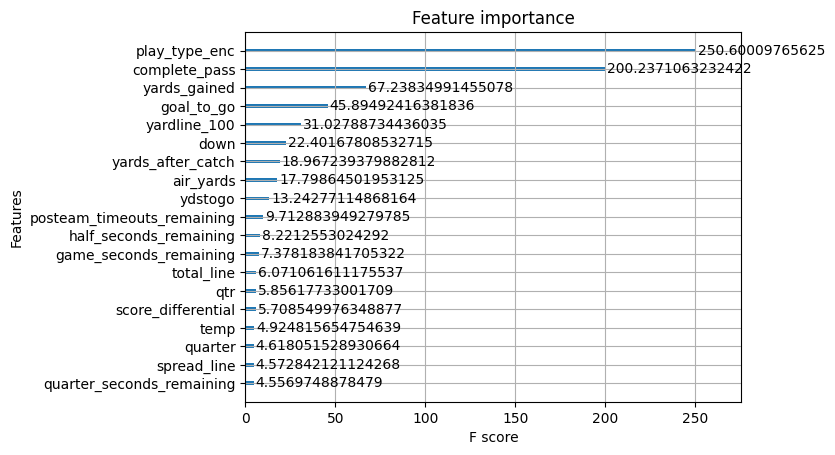

In [33]:
import xgboost as xgb
import matplotlib.pyplot as plt

# If oob_model is XGBClassifier / XGBRegressor
xgb.plot_importance(oob_model, importance_type='gain', max_num_features=20)
plt.show()


In [36]:
oob_model.predict_proba(pbp[oob_x].iloc[0:10])

array([[0.8863269 , 0.11367307],
       [0.8789089 , 0.1210911 ],
       [0.94713205, 0.05286793],
       [0.95579064, 0.04420939],
       [0.7552716 , 0.24472837],
       [0.91959023, 0.08040974],
       [0.94796467, 0.05203535],
       [0.85290945, 0.14709052],
       [0.9122182 , 0.08778177],
       [0.9757792 , 0.02422084]], dtype=float32)

In [ ]:
.33